In [1]:
import os
import sys
import gains as genetic
from gains.salt_generator import *
import pandas as pd
import rdkit
import pickle
from math import exp
import numpy as np
import random
import unittest
import datetime
import sys
import sklearn
import salty
from sklearn.linear_model import LinearRegression as lin
import matplotlib.pyplot as plt


from numpy import array, all
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator

%matplotlib inline

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

In [3]:
target = 1000
model_ID = "cpt_density_m1"
generate_solvent(target, model_ID, sim_bounds=[0.1, 1], heavy_atom_limit=1e8, hits=1)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


CCCCCCCCCCCC[N+](CC)(CC)CC	0.90669	starting structure
CCCCC(O)CCCCCCC[N+](CC)(CC)CC	0.908155	add_rdkit_fragment
CCCCC(CCCCCCC[N+](CC)(CC)CC)OCl	0.909725	add_atom
CCCC(CCCCCCC[N+](CC)(CC)CC)OCl	0.92834	remove_atom
CCCC(CCCCC(CC[N+](CC)(CC)CC)N=C=S)OCl	0.93375	add_rdkit_fragment
CCCC(CCC(S)CC(CC[N+](CC)(CC)CC)N=C=S)OCl	0.9374	add_rdkit_fragment
CCCC(CCC(S)CC(CC[N+](C)(CC)CC)N=C=S)OCl	0.95448	remove_atom
CCCC(CCC(S)CC(CC[N+](C)(CC)C(C)C(=O)O)N=C=S)OCl	0.954585	add_rdkit_fragment
CCCCC(C)(C(=O)O)[N+](C)(CC)CCC(CC(S)CCC(CCC)OCl)N=C=S	0.958825	add_custom_fragment
CCCCC(C)(C(=O)O)[N+](C)(CC)CCC(CC(S)CCC(CCCP)OCl)N=C=S	0.96289	add_atom
CCCCC(CCCP)(CCC(S)CC(CC[N+](C)(CC)C(C)(CCCC)C(=O)O)N=C=S)OCl	0.97074	add_custom_fragment
CCCCC[N+](CC)(CCC(CC(S)CCC(CCCC)(CCCP)OCl)N=C=S)C(C)(CCCC)C(=O)O	0.9742850000000001	add_custom_fragment
BC(CCCC)(C(=O)O)[N+](CC)(CCCCC)CCC(CC(S)CCC(CCCC)(CCCP)OCl)N=C=S	0.98167	replace_atom
BC(CCCC)(C(=O)O)[N+](CC)(CCCCC)CCC(CC(S)CCC(CCCC)(CPCP)OCl)N=C=S	0.98614	replace_atom

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Prediction,MD Calculation,Error
0,C01_A01,CCCCC[N+](CC)(CCC(CC(S)CCC(CCCC)(CPPP)OCl)N=C=...,39,0.519841,1-butyl-3-methylimidazolium,L-prolinate,"[1003.53, 1011.57]",NaN,NaN


In [6]:
salty.check_name("phosphate")

'[O-]P(=O)([O-])[O-]'

In [11]:
out = pd.DataFrame()
densities = ["1100", "1300", "1500"]
for k, l in enumerate(densities):
    for j in np.arange(40,100,10):
        df = pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/salt_log.csv" % (l,j)) #or salt_candidates
        inner = pd.DataFrame()
        for i in range(1,26):
            if i < 10:
                CAT_ID = "C0%s" % i
                AN_ID = "A0%s" % i
            else:
                CAT_ID = "C%s" % i
                AN_ID = "A%s" % i
            Salt_ID = CAT_ID + "_" + AN_ID
            try:
                mean = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/%s.dens" % (l, j, Salt_ID)).describe().loc["mean"][1])
                std = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/%skgm3/%s/%s.dens" % (l, j, Salt_ID)).describe().loc["std"][1])
                value = ("{}{}{}".format(mean," +/- ", std))
                true = df.loc[df["Salt ID"] == Salt_ID, "Model Density"]
                difference = (true - mean)/true*100
                df.loc[df["Salt ID"] == Salt_ID, "MD Density"] = value
                df.loc[df["Salt ID"] == Salt_ID, "Error"] = difference #this is % Difference in old version
            except:
                pass
        df.dropna(inplace=True)
        out = pd.concat([df, out], axis=0) 
    out.reset_index(drop=True, inplace=True)
out

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,Error
0,C03_A03,O=C(C[n+]1ccccc1)OCCO.O=S(=O)(F)[N-]S(=O)(=O)F,13,0.917647,1-(2-ethoxy-2-oxoethyl)-pyridinium,bis(fluorosulfonyl)amide,1514.04,1511.0 +/- 33.0,0.200787
1,C05_A05,COCCn1cc[n+](C)c1C.O=S(=O)([O-])C(F)(F)C(F)OC(...,11,0.915493,"1-(2-hydroxyethyl)-2,3-dimethylimidazolium","1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1502.11,1423.0 +/- 28.0,5.266592
2,C06_A06,C[n+]1ccn(CCCS(=O)(=O)OO)c1.O=S(=O)([N-]S(=O)(...,14,0.924528,1-methyl-3-(3-sulfopropyl)-imidazolium,bis[(trifluoromethyl)sulfonyl]imide,1498.09,1593.0 +/- 37.0,-6.335400
3,C09_A09,CCC[N+](C)(C)CCC.O=S(=O)([N-]S(=O)(=O)C(F)(F)C...,9,0.903226,"N-ethyl-N,N-dimethyl-1-propanaminium",bis(perfluoroethylsulfonyl)imide,1491.02,1453.0 +/- 51.0,2.549932
4,C11_A11,CC(S)CCCC[n+]1ccn(CCC#N)c1.O=S(=O)([O-])C(F)(F...,16,0.925373,3-(2-cyanoethyl)-1-hexyl-1H-imidazolium,"1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1496.91,1364.0 +/- 46.0,8.878957
5,C13_A13,Cn1cc[n+](CCCCCCOS)c1.O=S(=O)([O-])C(F)(F)C(F)...,14,0.930851,3-(6-hydroxyhexyl)-1-methylimidazolium,"1,1,2,3,3,3-hexafluoro-1-propanesulfonate",1500.32,1367.0 +/- 39.0,8.886104
6,C14_A14,N#CCCn1cc[n+](CC=CO)c1.O=S(=O)([N-]S(=O)(=O)C(...,13,0.932367,3-allyl-1-(2-cyanoethyl)-1H-imidazolium,bis(trifluoromethylsulfonyl)imide,1513.98,1512.0 +/- 33.0,0.130781
7,C15_A15,CC[n+]1ccn(CC(C)C)c1.O=S(=O)([N-]S(=O)(=O)C(F)...,11,0.963235,1-isobutyl-3-methylimidazolium,bis(perfluoroethylsulfonyl)imide,1488.39,1446.0 +/- 56.0,2.848044
8,C19_A19,CCSCCCn1c(C)cc(C)[n+]1-c1ccccc1.O=S(=O)([N-]S(...,19,0.913924,"1-phenyl-2-butyl-3,5-dimethylpyrazolium",bis(perfluoroethylsulfonyl)imide,1485.03,1376.0 +/- 32.0,7.341939
9,C22_A22,C[N+]1(C)CCOCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)F)...,8,0.916667,4-ethyl-4-methylmorpholin-4-ium,bis[(trifluoromethyl)sulfonyl]imide,1507.34,1608.0 +/- 47.0,-6.677989


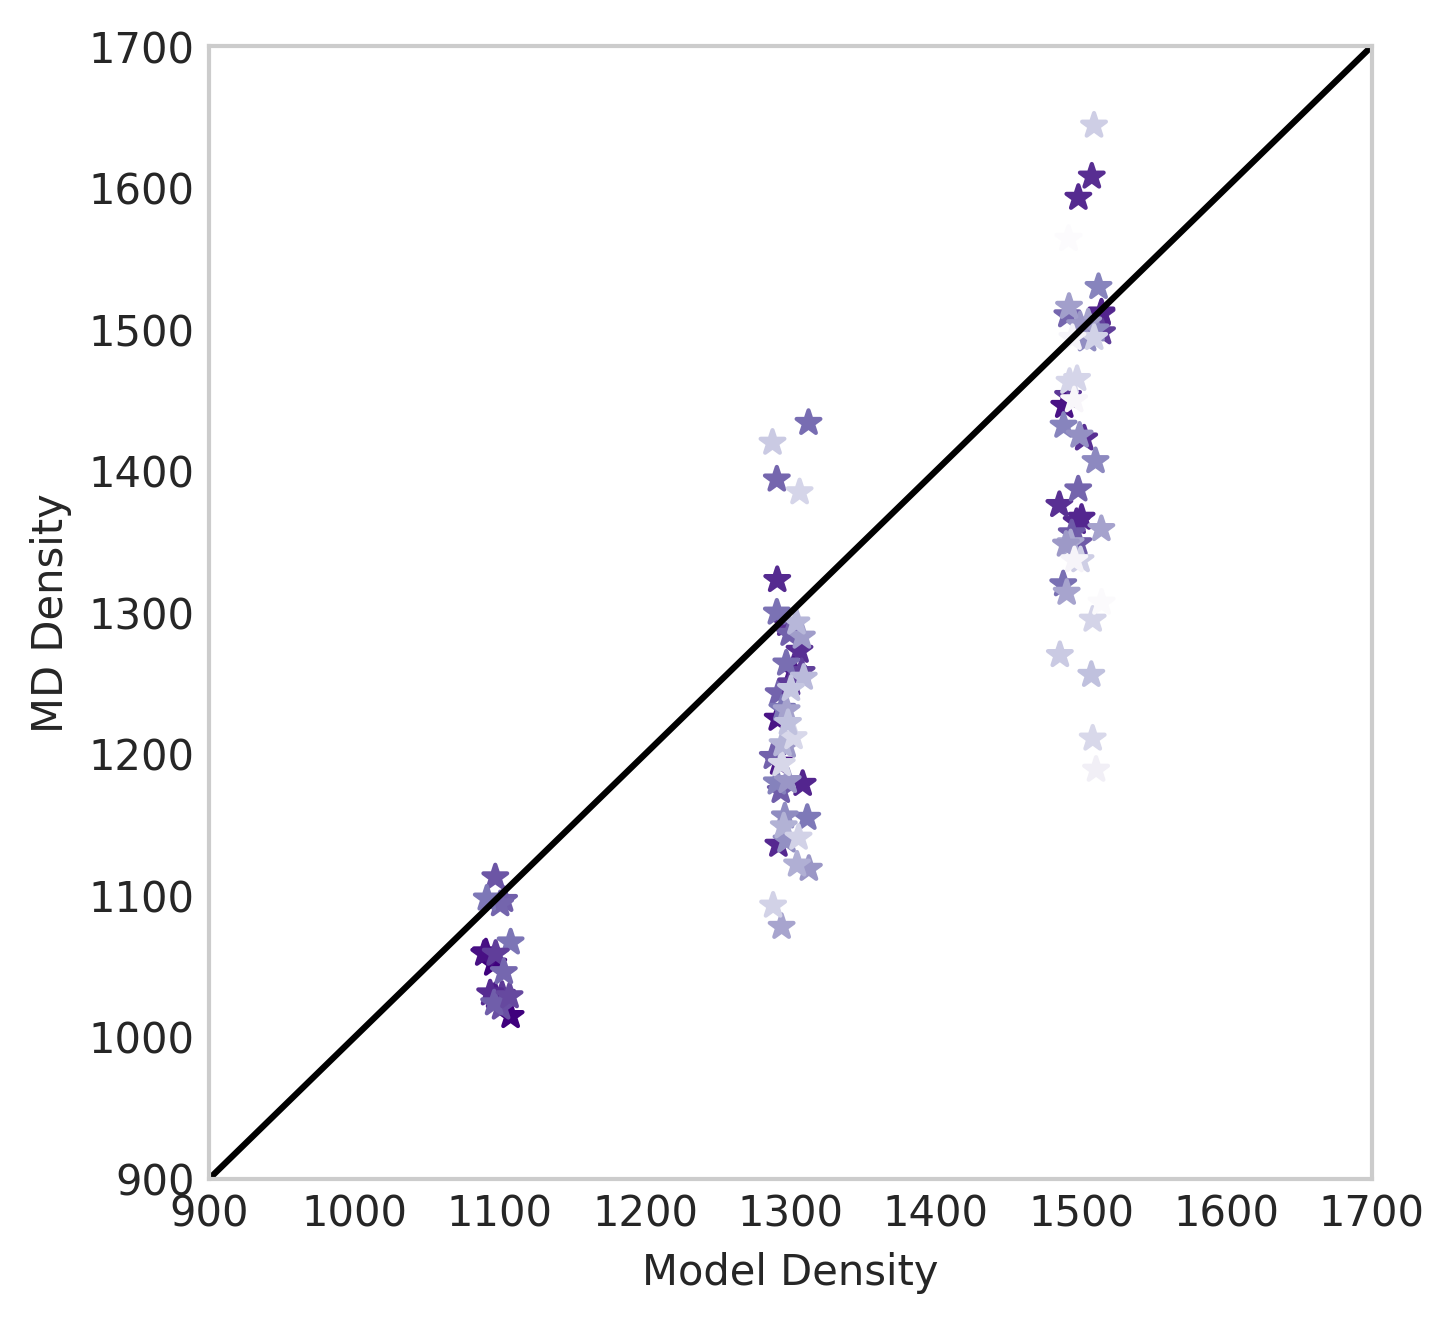

In [51]:
md = []
std = []
for i in range(out.shape[0]):
    md.append(float(out["MD Density"][i].split()[0]))
    std.append(float(out["MD Density"][i].split()[2]))
    
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax = fig.add_subplot(111)
    ax.errorbar(out["Model Density"], md, yerr=std, marker="*", linestyle="", alpha=0)
    ax.scatter(out["Model Density"], md, marker="*",
               c=out["Tanimoto Similarity Score"], cmap="Purples")
    
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    #ax.plot([0,X0],[Y0,0], label="Best fit R-squared: 0.25")
    #ax.set_xlim(0.4,1)
    #ax.set_ylim(0,11)
    #ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel("MD Density")
    ax.set_xlabel("Model Density")
    plt.xlim(900,1700)
    plt.ylim(900,1700)
    ax.grid()
    
# fig.savefig(filename='../../designer_molecules/6.eps', 
#                        bbox_inches='tight', format='eps') 

In [11]:
datadf

,steiger-anion,Marsili Partial Charges-anion,BalabanJ-anion,BertzCT-anion,Ipc-anion,HallKierAlpha-anion,Kappa1-anion,Kappa2-anion,Kappa3-anion,Chi0-anion,...,VSA_EState5-cation,VSA_EState6-cation,VSA_EState7-cation,VSA_EState8-cation,VSA_EState9-cation,VSA_EState10-cation,Topliss fragments-cation,"Temperature, K","Pressure, kPa","Specific density, kg/m<SUP>3</SUP>"
0,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.091026
1,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.091908
2,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.092158
3,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.091226
4,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.091884
5,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.680994,-0.028159,7.091468
6,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-0.702837,-0.028159,7.090535
7,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,0.753327,-0.028159,7.084838
8,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-1.773117,-0.028159,7.095479
9,0.0,0.0,-0.518062,-0.889952,-0.057020,0.361839,-0.663335,-0.953977,-0.256752,-0.624413,...,0.0,0.0,0.0,-0.369351,0.260034,0.018717,0.0,-1.409076,-0.028159,7.094069


In [2]:
import salty
import numpy as np

devmodel = salty.load_model(data_file_name="density_devmodel.pkl")
rawdf = devmodel.Data
#rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

In [52]:
out

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,Error
0,C03_A03,O=C(C[n+]1ccccc1)OCCO.O=S(=O)(F)[N-]S(=O)(=O)F,13,0.917647,1-(2-ethoxy-2-oxoethyl)-pyridinium,bis(fluorosulfonyl)amide,1514.04,1511.0 +/- 33.0,0.200787
1,C05_A05,COCCn1cc[n+](C)c1C.O=S(=O)([O-])C(F)(F)C(F)OC(...,11,0.915493,"1-(2-hydroxyethyl)-2,3-dimethylimidazolium","1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1502.11,1423.0 +/- 28.0,5.266592
2,C06_A06,C[n+]1ccn(CCCS(=O)(=O)OO)c1.O=S(=O)([N-]S(=O)(...,14,0.924528,1-methyl-3-(3-sulfopropyl)-imidazolium,bis[(trifluoromethyl)sulfonyl]imide,1498.09,1593.0 +/- 37.0,-6.335400
3,C09_A09,CCC[N+](C)(C)CCC.O=S(=O)([N-]S(=O)(=O)C(F)(F)C...,9,0.903226,"N-ethyl-N,N-dimethyl-1-propanaminium",bis(perfluoroethylsulfonyl)imide,1491.02,1453.0 +/- 51.0,2.549932
4,C11_A11,CC(S)CCCC[n+]1ccn(CCC#N)c1.O=S(=O)([O-])C(F)(F...,16,0.925373,3-(2-cyanoethyl)-1-hexyl-1H-imidazolium,"1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1496.91,1364.0 +/- 46.0,8.878957
5,C13_A13,Cn1cc[n+](CCCCCCOS)c1.O=S(=O)([O-])C(F)(F)C(F)...,14,0.930851,3-(6-hydroxyhexyl)-1-methylimidazolium,"1,1,2,3,3,3-hexafluoro-1-propanesulfonate",1500.32,1367.0 +/- 39.0,8.886104
6,C14_A14,N#CCCn1cc[n+](CC=CO)c1.O=S(=O)([N-]S(=O)(=O)C(...,13,0.932367,3-allyl-1-(2-cyanoethyl)-1H-imidazolium,bis(trifluoromethylsulfonyl)imide,1513.98,1512.0 +/- 33.0,0.130781
7,C15_A15,CC[n+]1ccn(CC(C)C)c1.O=S(=O)([N-]S(=O)(=O)C(F)...,11,0.963235,1-isobutyl-3-methylimidazolium,bis(perfluoroethylsulfonyl)imide,1488.39,1446.0 +/- 56.0,2.848044
8,C19_A19,CCSCCCn1c(C)cc(C)[n+]1-c1ccccc1.O=S(=O)([N-]S(...,19,0.913924,"1-phenyl-2-butyl-3,5-dimethylpyrazolium",bis(perfluoroethylsulfonyl)imide,1485.03,1376.0 +/- 32.0,7.341939
9,C22_A22,C[N+]1(C)CCOCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)F)...,8,0.916667,4-ethyl-4-methylmorpholin-4-ium,bis[(trifluoromethyl)sulfonyl]imide,1507.34,1608.0 +/- 47.0,-6.677989


In [198]:
#Some scratch code for re-evaluating predicted densities from smiles
target = 1000
model_ID = "density_m3"
#out_1000.reset_index(inplace=True)
for i in range(len(out_1000["Salt Smiles"])):
    genes = out_1000["Salt Smiles"][i].split(".")[0]
    anion = Chem.MolFromSmiles(out_1000["Salt Smiles"][i].split(".")[1])
    score, prediction = salt_generator.get_fitness(anion, genes, target, model_ID)
    if score < 0.95:
        print(i)
        out_1000.drop([i], inplace=True)
        out_1000.reset_index(inplace=True, drop=True)
        
    
    #out_1300["Model Density"][i] = prediction
    diff = (float(prediction) - float(out_1000["MD Density"][i].split()[0])) / float(out_1000["MD Density"][i].split()[0]) * 100
    #out_1300["% Difference"][i] = diff
    #print(score)
    #out_1000.reset_index(inplace=True)

20
21
25
35
37


KeyError: 42

In [53]:
#leftover from 1000kgm3 runs
out.drop([23,55,58], inplace=True)
out.reset_index(inplace=True)

In [ ]:
driver = webdriver.Chrome()
driver.get("http://www.chemspider.com/")
out.reset_index(inplace=True)
results=[]

In [ ]:
###This cell checks that entries are not existent in the world
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time

for i in range(52,out.shape[0]):
    ion = out["Salt Smiles"][i].split(".")[0]
    search = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_qs_query\"]")
    search.clear()
    search.send_keys(ion)
    submit = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_search_btn\"]")
    submit.click()
    time.sleep(5)
    try:
        name = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_ContentSection"\
                                            "_ContentPlaceHolder1_RecordViewDetails"\
                                            "_rptDetailsView_ctl00_WrapTitle\"]")
        results.append([ion, name.text])
        print(ion, name.text)
        time.sleep(3)
    except:
        results.append([ion, "new molecule"])
        print("{}\t{}".format("name not found for:",ion))

In [20]:
b = pd.DataFrame(a)
b.to_csv("existance_results.csv",index=False, indicator=True)

NameError: name 'a' is not defined

In [7]:
results
a = np.array(results)
a[:,1]

NameError: name 'results' is not defined

In [224]:
out_1000 = out_1000.loc[out_1000["Tanimoto Similarity Score"] > 0.9]
out_1300 = out_1300.loc[out_1300["Tanimoto Similarity Score"] > 0.9]
out_1500 = out_1500.loc[out_1500["Tanimoto Similarity Score"] > 0.9]

In [228]:
out_1000.reset_index(drop=True, inplace=True)
out_1300.reset_index(drop=True, inplace=True)
out_1500.reset_index(drop=True, inplace=True)

In [13]:
df = salty.load_data("cationInfo.csv")
parent_candidates = df["smiles"].unique()
to_plot=[]
for i in range(out.shape[0]):
    smi = out.iloc[i]["Salt Smiles"].split(".")[0]
    mol = Chem.MolFromSmiles(smi)
    chro = genetic.Chromosome(smi, 0)
    score, index = genetic.molecular_similarity(chro, parent_candidates, all=True)
    score.append(out.iloc[i]["Error"])
    to_plot.append(score)
points = np.array(to_plot)
sim_scores = []
for i in range(points.shape[1]-1):
    sim_scores.append(points[:,i])

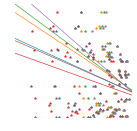

In [19]:
metrics = ["Tanimoto", "Dice", "Cosine", "Sokal", 
           "Kulczynski", "McConnaughey"]
r_sqr = []
import matplotlib.pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=30)
    ax = fig.add_subplot(111)
    for i in range(len(sim_scores)):
        X=sim_scores[i].reshape(-1,1)
        Y=np.abs(out["Error"]).values.reshape(-1,1)
        model = lin()
        model.fit(X,Y)
        if model.coef_ < 0:
            Y0=model.intercept_
            X0=abs(model.intercept_/model.coef_)
        else:
            print("pos corr")
        r_sqr.append(model.score(X,Y))
        for j in range(len(sim_scores[0])):
        
            if j == 0:
                ax.plot(sim_scores[i][j], np.abs(out.iloc[j]["Error"]), 
                        linestyle="", marker="*", c=tableau20[i*2],
                       label="{:3.4f}, {}".format(r_sqr[i], metrics[i]))
                ax.plot([0,X0],[Y0,0])
    
            else:
                ax.plot(sim_scores[i][j], np.abs(out.iloc[j]["Error"]), 
                        linestyle="", marker="*", c=tableau20[i*2])
    ax.set_xlim(0.2,1)
    ax.set_axis_off()
    ax.set_ylim(0,18)
    ax.set_ylabel("% Error")
    ax.set_xlabel("Similarity Score")
    #ax.legend(bbox_to_anchor=(1.6,1))
    
    ax.grid()
fig.savefig(filename='../../designer_molecules/11.eps', 
                       bbox_inches='tight', format='eps') 